# Spatiotemporal Prediction of Tidal Currents Using Gaussian Processes

This notebook implements a Bayesian Gaussian Process (GP) model following Sarkar et al. (2019) for predicting cross-currents from four research datasets. We:
1. Load and preprocess data
2. Define and train a spatiotemporal GP model
3. Evaluate predictions and visualize results

In [34]:
# System & data handling
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Sklearn utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# GP modeling with GPyTorch
import torch
import gpytorch

# For geospatial operations
from sklearn.metrics import mean_squared_error

In [35]:
data_dir = '../data/processed'
csv_files = {
    'water_height': os.path.join(data_dir, 'water_height_processed.csv'),
    'wind_direction': os.path.join(data_dir, 'wind_direction_processed.csv'),
    'flow_rate': os.path.join(data_dir, 'flow_rate_processed.csv'),
    'flow_direction': os.path.join(data_dir, 'flow_direction_processed.csv'),
}


In [36]:
# Columns to keep from each csv
cols = ['datetime_unix','NUMERIEKEWAARDE', 'X', 'Y']

# Load CSVs
dfs = {name: pd.read_csv(path, usecols=cols) for name, path in csv_files.items()}

In [37]:
# Merge into single DataFrame for modeling
df_all = pd.DataFrame()
df_all['water_height'] = dfs['water_height']['NUMERIEKEWAARDE']
df_all['wind_direction'] = dfs['wind_direction']['NUMERIEKEWAARDE']
df_all['flow_rate'] = dfs['flow_rate']['NUMERIEKEWAARDE']
df_all['flow_direction'] = dfs['flow_direction']['NUMERIEKEWAARDE']
df_all['X'] = dfs['water_height']['X']
df_all['Y'] = dfs['water_height']['Y']
df_all['datetime_unix'] = dfs['water_height']['datetime_unix']
df_all = df_all.dropna()


In [38]:
# Summary stats
print(df_all[['water_height','wind_direction', 'flow_rate', 'flow_direction']].describe())


       water_height  wind_direction     flow_rate  flow_direction
count  26171.000000    2.617100e+04  26171.000000    26171.000000
mean      -0.092450    2.932200e-16     -0.000944        0.000238
std        0.992945    1.000000e+00      0.999800        1.000116
min       -1.775431   -1.670827e+00     -3.262918       -0.666535
25%       -0.975624   -8.344454e-01     -0.691011       -0.661498
50%       -0.229138    1.215567e-01     -0.111420       -0.656109
75%        0.748404    7.138728e-01      0.592280        1.221579
max        2.188056    1.801072e+00      4.019032        2.951847


In [39]:
# Features & target
y_speed = df_all['flow_rate'].values
y_direction = df_all['flow_direction'].values
y = np.column_stack([y_speed, y_direction])

X_feat = df_all[['wind_direction','water_height']].values

timestamps = df_all['datetime_unix']
timestamps = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())
temporal_features = timestamps.to_numpy().reshape(-1, 1)

# Combine spatial + temporal + predictors
X = np.hstack([X_feat, timestamps.values.reshape(-1,1)])

print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")

# Chronological split
train_cut = int(0.80*len(df_all))
X_train, X_test = X[:train_cut], X[train_cut:]
y_train, y_test = y[:train_cut], y[train_cut:]

Feature matrix shape: (26171, 3)
Target matrix shape: (26171, 2)


In [40]:
# Check your data loading
print(f"df_all shape: {df_all.shape}")
print(f"df_all columns: {df_all.columns.tolist()}")

# Check if the columns exist and have data
print(f"flow_rate column exists: {'flow_rate' in df_all.columns}")
print(f"flow_direction column exists: {'flow_direction' in df_all.columns}")

if 'flow_rate' in df_all.columns:
    print(f"flow_rate non-null count: {df_all['flow_rate'].notna().sum()}")
    print(f"flow_rate sample values: {df_all['flow_rate'].head()}")

if 'flow_direction' in df_all.columns:
    print(f"flow_direction non-null count: {df_all['flow_direction'].notna().sum()}")
    print(f"flow_direction sample values: {df_all['flow_direction'].head()}")

# Check the y array after creation
print(f"y_speed shape: {y_speed.shape}")
print(f"y_direction shape: {y_direction.shape}")
print(f"y shape after column_stack: {y.shape}")

# Check for NaN values
print(f"NaN values in y_speed: {np.isnan(y_speed).sum()}")
print(f"NaN values in y_direction: {np.isnan(y_direction).sum()}")
print(f"NaN values in y: {np.isnan(y).sum()}")

# Check the train split
print(f"y_train shape: {y_train.shape}")
print(f"y_train columns: {y_train.shape[1] if len(y_train.shape) > 1 else '1D'}")

df_all shape: (26171, 7)
df_all columns: ['water_height', 'wind_direction', 'flow_rate', 'flow_direction', 'X', 'Y', 'datetime_unix']
flow_rate column exists: True
flow_direction column exists: True
flow_rate non-null count: 26171
flow_rate sample values: 0   -0.594344
1   -0.295333
2    0.054879
3    0.606616
4    1.273453
Name: flow_rate, dtype: float64
flow_direction non-null count: 26171
flow_direction sample values: 0    1.554361
1    1.630770
2   -0.664051
3   -0.664363
4   -0.664956
Name: flow_direction, dtype: float64
y_speed shape: (26171,)
y_direction shape: (26171,)
y shape after column_stack: (26171, 2)
NaN values in y_speed: 0
NaN values in y_direction: 0
NaN values in y: 0
y_train shape: (20936, 2)
y_train columns: 2


In [41]:
class SpatioTemporalGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        kern_feat = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(active_dims=list(range(2)))
        )
        kern_time = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, active_dims=[2])
        )
        self.covar_module = kern_feat * kern_time

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Train separate models for each output
def train_gp_model(X_train, y_train, epochs=2):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    train_x_tensor = torch.tensor(X_train).float()
    train_y_tensor = torch.tensor(y_train).float()
    model = SpatioTemporalGP(train_x_tensor, train_y_tensor, likelihood)
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model = model.to(device)
        likelihood = likelihood.to(device)
        train_x_tensor = train_x_tensor.to(device)
        train_y_tensor = train_y_tensor.to(device)
    else:
        device = torch.device('cpu')
    
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(1, epochs+1):
        optimizer.zero_grad()
        output = model(train_x_tensor)
        loss = -mll(output, train_y_tensor)
        loss.backward()
        optimizer.step()
        if i % 10 == 0 or i == 1:
            print(f"Iter {i}/{epochs} - Loss: {loss.item():.3f}")
    
    return model, likelihood

In [42]:
# Check the exact error location
print(f"y_train[:, 0] shape: {y_train[:, 0].shape}")
print(f"y_train[:, 1] shape: {y_train[:, 1].shape}")

# Check if there are any infinite values
print(f"Infinite values in y_train[:, 0]: {np.isinf(y_train[:, 0]).sum()}")
print(f"Infinite values in y_train[:, 1]: {np.isinf(y_train[:, 1]).sum()}")


# Train models
print("Training water speed model...")
model_speed, likelihood_speed = train_gp_model(X_train, y_train[:, 0])

print("Training water direction model...")
model_direction, likelihood_direction = train_gp_model(X_train, y_train[:, 1])

# Predictions
def predict_gp(model, likelihood, X_test):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x_tensor = torch.tensor(X_test).float()
        pred = likelihood(model(test_x_tensor))
        return pred.mean.numpy()

pred_speed = predict_gp(model_speed, likelihood_speed, X_test)
pred_direction = predict_gp(model_direction, likelihood_direction, X_test)

# Combine predictions into tuple format
predictions = list(zip(pred_speed, pred_direction))

print(f"Predicted tuples: {predictions[:5]}")  # Show first 5 predictions

y_train[:, 0] shape: (20936,)
y_train[:, 1] shape: (20936,)
Infinite values in y_train[:, 0]: 0
Infinite values in y_train[:, 1]: 0
Training water speed model...


KeyboardInterrupt: 

In [ ]:
# Calculate metrics for water speed
rmse_speed = np.sqrt(mean_squared_error(y_test[:, 0], pred_speed))
mae_speed = mean_absolute_error(y_test[:, 0], pred_speed)
r2_speed = r2_score(y_test[:, 0], pred_speed)

# Calculate metrics for water direction
rmse_direction = np.sqrt(mean_squared_error(y_test[:, 1], pred_direction))
mae_direction = mean_absolute_error(y_test[:, 1], pred_direction)
r2_direction = r2_score(y_test[:, 1], pred_direction)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"\nWater Speed:")
print(f"  RMSE: {rmse_speed:.4f}")
print(f"  MAE:  {mae_speed:.4f}")
print(f"  R²:   {r2_speed:.4f}")

print(f"\nWater Direction:")
print(f"  RMSE: {rmse_direction:.4f}")
print(f"  MAE:  {mae_direction:.4f}")
print(f"  R²:   {r2_direction:.4f}")

=== MODEL PERFORMANCE METRICS ===

Water Speed:
  RMSE: 2.8892
  MAE:  2.7195
  R²:   -7.7667

Water Direction:
  RMSE: 0.9619
  MAE:  0.8769
  R²:   -0.0056


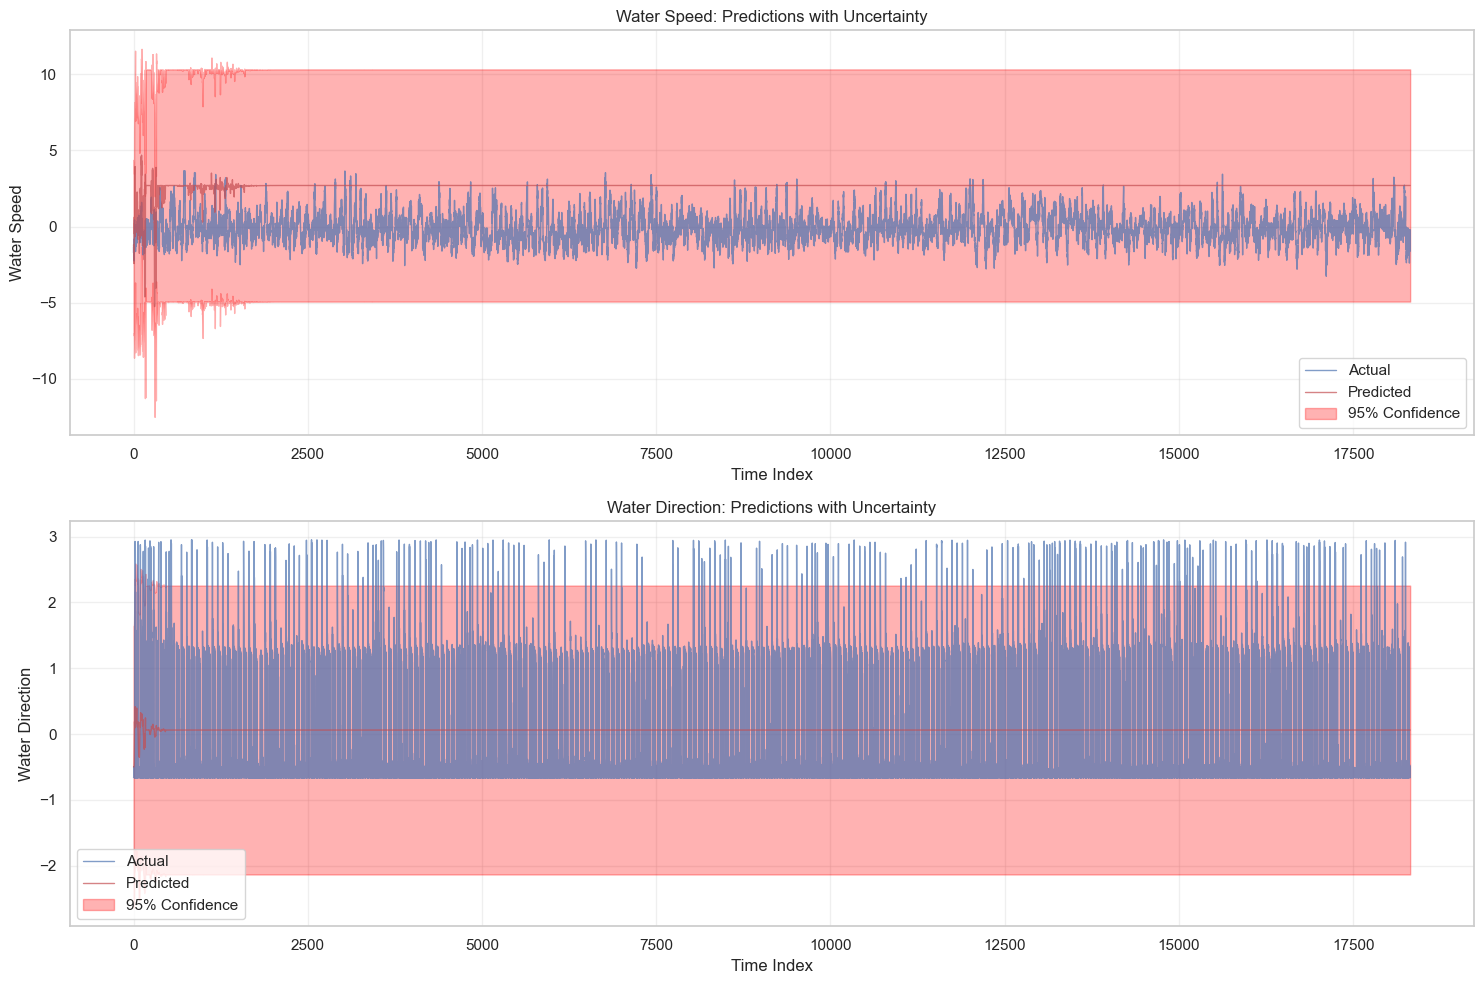

In [ ]:
# Get prediction uncertainties
def predict_with_uncertainty(model, likelihood, X_test):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x_tensor = torch.tensor(X_test).float()
        pred = likelihood(model(test_x_tensor))
        mean = pred.mean.numpy()
        std = pred.stddev.numpy()
        return mean, std

# Get predictions with uncertainty
mean_speed, std_speed = predict_with_uncertainty(model_speed, likelihood_speed, X_test)
mean_direction, std_direction = predict_with_uncertainty(model_direction, likelihood_direction, X_test)

# Plot with confidence intervals
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Water Speed with confidence intervals
time_indices = range(len(y_test))
axes[0].plot(time_indices, y_test[:, 0], 'b-', label='Actual', alpha=0.7, linewidth=1)
axes[0].plot(time_indices, mean_speed, 'r-', label='Predicted', alpha=0.7, linewidth=1)
axes[0].fill_between(time_indices, 
                     mean_speed - 2*std_speed, 
                     mean_speed + 2*std_speed, 
                     alpha=0.3, color='red', label='95% Confidence')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('Water Speed')
axes[0].set_title('Water Speed: Predictions with Uncertainty')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Water Direction with confidence intervals
axes[1].plot(time_indices, y_test[:, 1], 'b-', label='Actual', alpha=0.7, linewidth=1)
axes[1].plot(time_indices, mean_direction, 'r-', label='Predicted', alpha=0.7, linewidth=1)
axes[1].fill_between(time_indices, 
                     mean_direction - 2*std_direction, 
                     mean_direction + 2*std_direction, 
                     alpha=0.3, color='red', label='95% Confidence')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Water Direction')
axes[1].set_title('Water Direction: Predictions with Uncertainty')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics
print("=== DETAILED MODEL ANALYSIS ===")

print(f"\nWater Speed Model:")
print(f"  RMSE: {rmse_speed:.4f}")
print(f"  MAE:  {mae_speed:.4f}")
print(f"  R²:   {r2_speed:.4f}")
print(f"  Mean prediction uncertainty: {np.mean(std_speed):.4f}")
print(f"  Actual range: [{y_test[:, 0].min():.4f}, {y_test[:, 0].max():.4f}]")
print(f"  Predicted range: [{pred_speed.min():.4f}, {pred_speed.max():.4f}]")

print(f"\nWater Direction Model:")
print(f"  RMSE: {rmse_direction:.4f}")
print(f"  MAE:  {mae_direction:.4f}")
print(f"  R²:   {r2_direction:.4f}")
print(f"  Mean prediction uncertainty: {np.mean(std_direction):.4f}")
print(f"  Actual range: [{y_test[:, 1].min():.4f}, {y_test[:, 1].max():.4f}]")
print(f"  Predicted range: [{pred_direction.min():.4f}, {pred_direction.max():.4f}]")

# Overall model assessment
print(f"\n=== MODEL ASSESSMENT ===")
if r2_speed > 0.7 and r2_direction > 0.7:
    print("✓ Excellent model performance (R² > 0.7)")
elif r2_speed > 0.5 and r2_direction > 0.5:
    print("✓ Good model performance (R² > 0.5)")
elif r2_speed > 0.3 and r2_direction > 0.3:
    print("~ Moderate model performance (R² > 0.3)")
else:
    print("✗ Poor model performance (R² < 0.3)")

print(f"Average R²: {(r2_speed + r2_direction) / 2:.4f}")

=== DETAILED MODEL ANALYSIS ===

Water Speed Model:
  RMSE: 2.8892
  MAE:  2.7195
  R²:   -7.7667
  Mean prediction uncertainty: 3.8062
  Actual range: [-3.2629, 3.6635]
  Predicted range: [-5.2531, 4.6787]

Water Direction Model:
  RMSE: 0.9619
  MAE:  0.8769
  R²:   -0.0056
  Mean prediction uncertainty: 1.0970
  Actual range: [-0.6665, 2.9518]
  Predicted range: [-0.4980, 0.4175]

=== MODEL ASSESSMENT ===
✗ Poor model performance (R² < 0.3)
Average R²: -3.8861
